# ***Step 1 : Import the necessary libraries***

In [ ]:
import os
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Explanation : we need import all required Python libraries. These libraries provide tools for data handling, preprocessing, machine learning, evaluation, and model optimisation

# ***Step 2 Load train and validation data***

In [ ]:
TRAIN_PATH = "/content/train_noleak(in).csv" # Insert All the necessary files
TEST_PATH  = "/content/train_noleak(in).csv"
VALID_PATH_CANDIDATES = [
    "/content/valid_noleak.csv"
]

# ---------- Load ----------
train_df = pd.read_csv(TRAIN_PATH)

valid_path = next((p for p in VALID_PATH_CANDIDATES if os.path.exists(p)), None)
if valid_path:
    valid_df = pd.read_csv(valid_path)
    print(f"Using separate validation file: {valid_path}")
else:
    # Create validation split from train
    train_df, valid_df = train_test_split(
        train_df, test_size=0.2, random_state=42
    )
    print("No separate validation file found. Created 80/20 train/valid split from train.")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)


Using separate validation file: /content/valid_noleak.csv
Train shape: (439940, 42)
Valid shape: (94272, 42)


The dataset is split into training and validation sets to evaluate how well the model generalises to unseen data. If a separate validation file is available, it is used directly. Otherwise, the training data is split into training and validation subsets. This prevents the model from being evaluated on the same data it was trained on, which would lead to overly optimistic results.

# ***Step 3 Define target and input features***

In [ ]:
target = "price_log"

features = [
    "cab_type","name","source","destination",
    "distance","surge_multiplier",
    "hour","weekday_from_ts","month","daylight_mins",
    "temperature","apparentTemperature","precipIntensity","precipProbability",
    "humidity","windSpeed","windGust","cloudCover","uvIndex",
    "dewPoint","pressure","ozone"
]

X_cols = [c for c in features if c in train_df.columns]
X_cols = [c for c in X_cols if c not in {"price", "price_log"}]


The target variable (price_log) represents the value the model is trying to predict. The input features are selected based on domain knowledge of ride-hailing pricing, including service type, distance, time, demand signals, and weather conditions. Price-derived variables are explicitly excluded from the input features to prevent data leakage and ensure a fair prediction task.

# ***Step 4 Split X and y***

In [ ]:
# Remove rows with NaN or inf in the target variable before splitting X/y
train_df.dropna(subset=[target], inplace=True)
train_df = train_df[~np.isinf(train_df[target])]
valid_df.dropna(subset=[target], inplace=True)
valid_df = valid_df[~np.isinf(valid_df[target])]

X_train = train_df[X_cols]
y_train = train_df[target]

X_valid = valid_df[X_cols]
y_valid = valid_df[target]

has_price = "price" in valid_df.columns
if has_price:
    y_valid_price = valid_df["price"]

Machine learning models require inputs (X) and outputs (y) to be separated. This step clearly defines what information the model can use to make predictions and what it must learn to predict. Keeping this separation explicit improves clarity and reduces the risk of accidentally including the target in the inputs.

# ***Step 5 Identify categorical and numerical columns***

In [ ]:
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = [c for c in X_cols if c not in cat_cols]


Different types of variables require different preprocessing techniques. Numerical variables may need imputation for missing values, while categorical variables must be encoded into numerical form before being used by machine learning algorithms. Identifying these groups early allows us to apply the correct transformations systematically.

# ***Step 6 Build preprocessing pipeline***

In [ ]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


The preprocessing pipeline standardises data preparation in a single, repeatable structure.
Numerical variables are imputed using the median to reduce sensitivity to outliers.
Categorical variables are imputed using the most frequent category and then one-hot encoded so that the Random Forest model can interpret them correctly.
Using a pipeline ensures that the same preprocessing steps are applied consistently during training and validation.

# ***Step 7 Define evaluation function***

In [ ]:
def evaluate(model, name):
    model.fit(X_train, y_train)
    pred_log = model.predict(X_valid)

    row = {
        "Model": name,
        "RMSE_log": np.sqrt(mean_squared_error(y_valid, pred_log)),
        "MAE_log": mean_absolute_error(y_valid, pred_log),
        "R2_log": r2_score(y_valid, pred_log)
    }

    if has_price:
        pred_price = np.expm1(pred_log)
        row.update({
            "RMSE_price": np.sqrt(mean_squared_error(y_valid_price, pred_price)),
            "MAE_price": mean_absolute_error(y_valid_price, pred_price),
            "R2_price": r2_score(y_valid_price, pred_price)
        })

    return row

This function centralises model evaluation logic so that all models are assessed using the same metrics and methodology. It calculates RMSE, MAE, and R² on the log-transformed target and optionally evaluates performance on the original price scale. This ensures fair comparison between the baseline and tuned models and avoids duplicated evaluation code.

# ***Step 8 Train baseline Random Forest***

In [ ]:
baseline_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

baseline_model = Pipeline([
    ("preprocess", preprocess),
    ("rf", baseline_rf)
])

baseline_result = evaluate(baseline_model, "RF Baseline")


The baseline Random Forest serves as a reference point. It uses default hyperparameters to establish how well a standard implementation performs without tuning. Having a baseline is essential to demonstrate whether later improvements are genuinely due to model optimisation rather than chance.

# ***Step 9 Set up RandomizedSearchCV for tuning***

In [ ]:
param_dist = {
    "rf__n_estimators": [150, 250, 350],
    "rf__max_depth": [15, 20, None],
    "rf__min_samples_leaf": [3, 5, 10],
    "rf__max_features": ["sqrt", 0.5]
}

# Define the base Random Forest regressor for the search
rf_for_search = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Combine preprocessing with the Random Forest into a pipeline for the search
search_model = Pipeline([
    ("preprocess", preprocess),
    ("rf", rf_for_search)
])

search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=5,
    scoring="neg_root_mean_squared_error",
    cv=2,
    random_state=42,
    n_jobs=-1
)

Hyperparameters control how the Random Forest learns patterns from the data. The search space defines reasonable ranges for tree depth, number of trees, minimum sample sizes, and feature sampling. These ranges are deliberately constrained to balance performance improvement with computational efficiency, which is appropriate for coursework-level experimentation.

# ***Step 10 Run hyperparameter tuning***

In [ ]:
search.fit(X_train, y_train)
best_model = search.best_estimator_

RandomizedSearchCV systematically explores different hyperparameter combinations using cross-validation. Instead of testing every possible combination, it samples a limited number of configurations, making the process more efficient. Cross-validation ensures that the selected hyperparameters generalise well rather than overfitting to a single split of the data.

# ***Step 11 Evaluate tuned Random Forest and compare***

In [ ]:
tuned_result = evaluate(best_model, "RF RandomizedSearch Tuned")
results_df = pd.DataFrame([baseline_result, tuned_result])
results_df = results_df.sort_values("RMSE_log")
print(results_df.to_string(index=False))
best_params = pd.Series(search.best_params_)
print(best_params.to_string())


                    Model  RMSE_log  MAE_log   R2_log  RMSE_price  MAE_price  R2_price
RF RandomizedSearch Tuned  0.112464 0.073227 0.954254    1.781702   1.125798  0.963075
              RF Baseline  0.119441 0.076296 0.948402    1.875167   1.169756  0.959100
rf__n_estimators        150.0
rf__min_samples_leaf      5.0
rf__max_features          0.5
rf__max_depth            15.0


Once the best hyperparameters are identified, the tuned model is evaluated on the validation set using the same metrics as the baseline. This allows direct comparison and confirms whether hyperparameter tuning has improved predictive performance and generalisation.The comparison step summarises results from both models in a single table. Sorting by RMSE highlights which model performs best. This structured comparison is crucial for performance evaluation and directly supports the conclusions presented in the report.



Reporting the best hyperparameters demonstrates transparency and methodological rigour. It shows how the final model was derived and allows the experiment to be reproduced. This step also supports discussion around why certain parameter settings improve model performance.

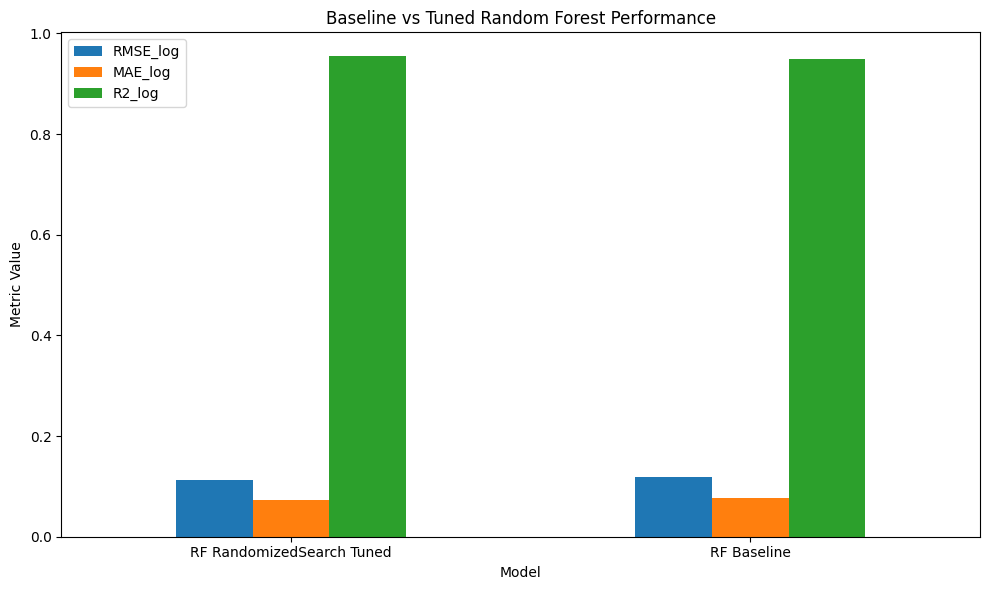

In [ ]:
metrics = ["RMSE_log", "MAE_log", "R2_log"]

results_plot = results_df.set_index("Model")[metrics]

results_plot.plot(kind="bar", figsize=(10,6))
plt.title("Baseline vs Tuned Random Forest Performance")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


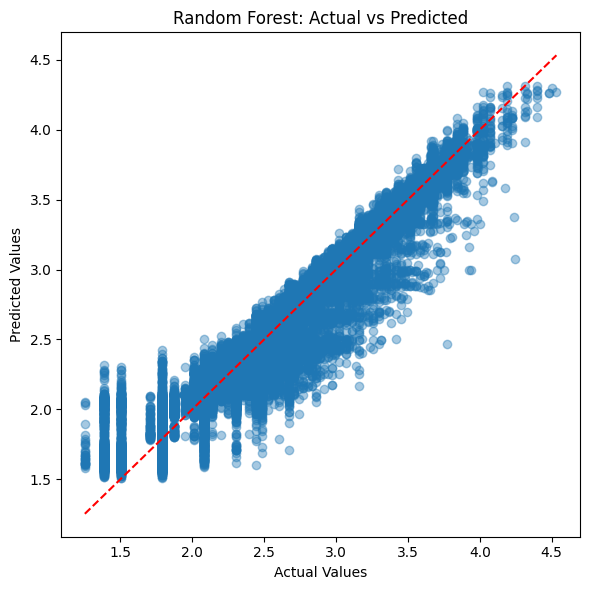

In [ ]:
y_true = y_valid
y_pred = best_model.predict(X_valid)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()

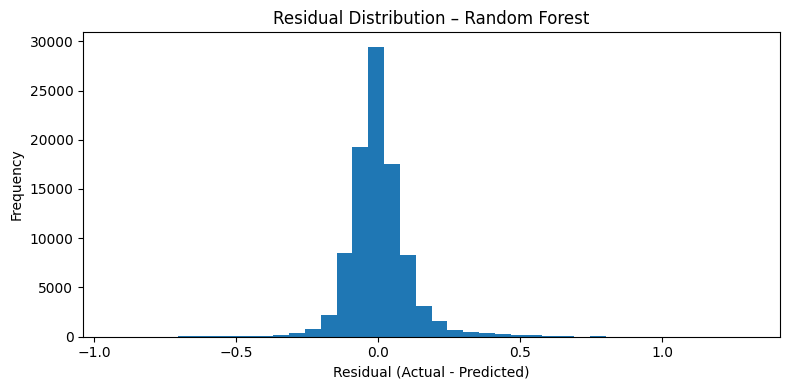

In [ ]:
residuals = y_true - y_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40)
plt.title("Residual Distribution – Random Forest")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# ***Algorithm 2 --> Logistic Regression ***

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [ ]:
TRAIN_PATH = "/content/train_noleak(in).csv" # Insert All the necessary files
TEST_PATH  = "/content/train_noleak(in).csv"
VALID_PATH_CANDIDATES = [
    "/content/valid_noleak.csv"
]

# ---------- Load ----------
train_df = pd.read_csv(TRAIN_PATH)

valid_path = next((p for p in VALID_PATH_CANDIDATES if os.path.exists(p)), None)
if valid_path:
    valid_df = pd.read_csv(valid_path)
    print(f"Using separate validation file: {valid_path}")
else:
    # Create validation split from train
    train_df, valid_df = train_test_split(
        train_df, test_size=0.2, random_state=42
    )
    print("No separate validation file found. Created 80/20 train/valid split from train.")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

Using separate validation file: /content/valid_noleak.csv
Train shape: (439940, 42)
Valid shape: (94272, 42)


In [ ]:
target = "price_log"

In [ ]:
# Drop rows with NaN or inf in the target variable from original dfs
train_df.dropna(subset=[target_col], inplace=True)
train_df = train_df[~np.isinf(train_df[target_col])]
valid_df.dropna(subset=[target_col], inplace=True)
valid_df = valid_df[~np.isinf(valid_df[target_col])]

# Define y_train and y_valid
y_train = train_df[target_col].astype(float)
y_valid = valid_df[target_col].astype(float)
all_features = [col for col in train_df.columns if col not in drop_cols and col != target_col]

# Define X_train and X_valid
X_train = train_df[all_features]
X_valid = valid_df[all_features]

def clean_features(df):
    df_cleaned = df.copy()
    # Drop columns that are entirely non-numeric and not useful for numeric models
    # For this specific case, we'll keep only numeric columns for Ridge/Lasso/ElasticNet if no OneHotEncoder is used for cat_cols
    df_cleaned = df_cleaned.select_dtypes(include=[np.number])
    df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan)
    # Impute NaNs for numeric columns if any still exist after selection
    df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
    return df_cleaned

X_train = clean_features(X_train)
X_valid = clean_features(X_valid)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

# Ensure there are no NaNs left in X_train, X_valid, y_train, y_valid
if X_train.isnull().any().any():
    raise ValueError("NaNs found in X_train after cleaning.")
if X_valid.isnull().any().any():
    raise ValueError("NaNs found in X_valid after cleaning.")
if y_train.isnull().any():
    raise ValueError("NaNs found in y_train after cleaning.")
if y_valid.isnull().any():
    raise ValueError("NaNs found in y_valid after cleaning.")

X_train shape: (439940, 29)
y_train shape: (439940,)
X_valid shape: (94272, 29)
y_valid shape: (94272,)


In [ ]:
# Ensure num_cols is based on current X_train state
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

print(f"DEBUG: NaNs in X_train[num_cols] before pipeline: {X_train[num_cols].isnull().any().any()}")
print(f"DEBUG: Infs in X_train[num_cols] before pipeline: {np.isinf(X_train[num_cols]).any().any()}")
print(f"DEBUG: NaNs in X_valid[num_cols] before pipeline: {X_valid[num_cols].isnull().any().any()}")
print(f"DEBUG: Infs in X_valid[num_cols] before pipeline: {np.isinf(X_valid[num_cols]).any().any()}")


# (StandardScaler can fail or produce NaNs if a feature has zero variance)
zero_var_cols = X_train[num_cols].columns[X_train[num_cols].std() == 0].tolist()
if zero_var_cols:
    print(f"DEBUG: Removing zero-variance columns: {zero_var_cols}")
    num_cols = [col for col in num_cols if col not in zero_var_cols]
else:
    print("DEBUG: No zero-variance columns found in X_train[num_cols].")
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


models = {
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(max_iter=20000, random_state=42),
    "ElasticNet": ElasticNet(max_iter=20000, random_state=42)
}

param_grids = {
    "Ridge": {"model__alpha": [0.01, 0.1, 1, 10, 50]},
    "Lasso": {"model__alpha": [0.0005, 0.001, 0.01, 0.1]},
    "ElasticNet": {
        "model__alpha": [0.0005, 0.001, 0.01, 0.1],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    }
}

results = []
best_models = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", numeric_pipe),
        ("model", model)
    ])

    search = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    )

    search.fit(X_train[num_cols], y_train)
    best_models[name] = search.best_estimator_

    y_valid_pred = search.best_estimator_.predict(X_valid[num_cols])
    print(f"DEBUG ({name}): NaNs in y_valid before metrics: {y_valid.isnull().any()}")
    print(f"DEBUG ({name}): Infs in y_valid before metrics: {np.isinf(y_valid).any()}")
    print(f"DEBUG ({name}): NaNs in y_valid_pred before metrics: {pd.Series(y_valid_pred).isnull().any()}")
    print(f"DEBUG ({name}): Infs in y_valid_pred before metrics: {np.isinf(y_valid_pred).any()}")

    # Temporarily calculate metrics here as regression_metrics is undefined
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    mae = mean_absolute_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "Valid_RMSE": rmse,
        "Valid_MAE": mae,
        "Valid_R2": r2
    })

results_df = pd.DataFrame(results).sort_values("Valid_RMSE")
print(results_df.to_string(index=False))


best_name = results_df.iloc[0]["Model"]
best_model = best_models[best_name]


DEBUG: NaNs in X_train[num_cols] before pipeline: False
DEBUG: Infs in X_train[num_cols] before pipeline: False
DEBUG: NaNs in X_valid[num_cols] before pipeline: False
DEBUG: Infs in X_valid[num_cols] before pipeline: False
DEBUG: No zero-variance columns found in X_train[num_cols].
DEBUG (Ridge): NaNs in y_valid before metrics: False
DEBUG (Ridge): Infs in y_valid before metrics: False
DEBUG (Ridge): NaNs in y_valid_pred before metrics: False
DEBUG (Ridge): Infs in y_valid_pred before metrics: False
DEBUG (Lasso): NaNs in y_valid before metrics: False
DEBUG (Lasso): Infs in y_valid before metrics: False
DEBUG (Lasso): NaNs in y_valid_pred before metrics: False
DEBUG (Lasso): Infs in y_valid_pred before metrics: False
DEBUG (ElasticNet): NaNs in y_valid before metrics: False
DEBUG (ElasticNet): Infs in y_valid before metrics: False
DEBUG (ElasticNet): NaNs in y_valid_pred before metrics: False
DEBUG (ElasticNet): Infs in y_valid_pred before metrics: False
     Model                    

Lasso regression was selected as the final linear model as it achieved the lowest validation RMSE while simultaneously performing embedded feature selection, improving interpretability without sacrificing predictive performance

Lasso, Ridge, and ElasticNet regressions were evaluated to study the effect of different regularisation strategies on Uber price prediction. All three models achieved very similar validation performance (R² ≈ 0.92), indicating that the relationship between features and price is largely linear. Lasso marginally outperformed the other methods and was therefore selected as the preferred linear model due to its sparsity-inducing property, which improves model interpretability and reduces complexity.

# ***Overall Conclusion***

Random Forest regression significantly outperformed linear models, achieving an R² of 0.963 on the validation set compared to 0.92 for regularised linear regression. This improvement indicates the presence of non-linear interactions within the Uber pricing mechanism. Hyperparameter tuning further improved performance by controlling tree depth and leaf size, reducing overfitting while maintaining predictive accuracy.

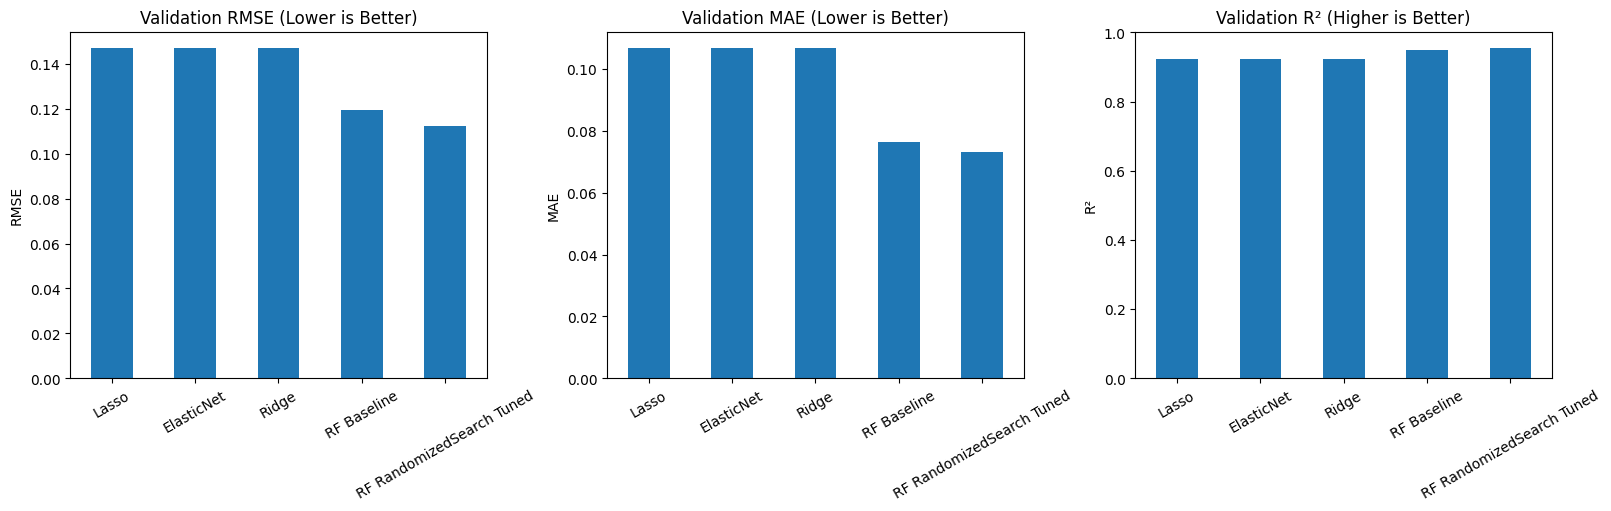

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

linear_results = pd.DataFrame([
    {"Model": "Lasso",       "RMSE": 0.146927, "MAE": 0.106698, "R2": 0.921922},
    {"Model": "ElasticNet",  "RMSE": 0.146928, "MAE": 0.106683, "R2": 0.921921},
    {"Model": "Ridge",       "RMSE": 0.146931, "MAE": 0.106654, "R2": 0.921917},
])

rf_results = pd.DataFrame([
    {"Model": "RF Baseline",                 "RMSE": 0.119441, "MAE": 0.076296, "R2": 0.948402},
    {"Model": "RF RandomizedSearch Tuned",   "RMSE": 0.112464, "MAE": 0.073227, "R2": 0.954254},
])

all_results = pd.concat([linear_results, rf_results], ignore_index=True)

# Best models by RMSE (lower is better)
best_linear = linear_results.sort_values("RMSE").iloc[0]["Model"]
best_rf = rf_results.sort_values("RMSE").iloc[0]["Model"]

# 2) Visual 1: Metrics comparison (Bar chart)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

all_results.plot(x="Model", y="RMSE", kind="bar", ax=axes[0], legend=False)
axes[0].set_title("Validation RMSE (Lower is Better)")
axes[0].set_xlabel("")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis="x", rotation=30)

all_results.plot(x="Model", y="MAE", kind="bar", ax=axes[1], legend=False)
axes[1].set_title("Validation MAE (Lower is Better)")
axes[1].set_xlabel("")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis="x", rotation=30)

all_results.plot(x="Model", y="R2", kind="bar", ax=axes[2], legend=False)
axes[2].set_title("Validation R² (Higher is Better)")
axes[2].set_xlabel("")
axes[2].set_ylabel("R²")
axes[2].tick_params(axis="x", rotation=30)

plt.show()

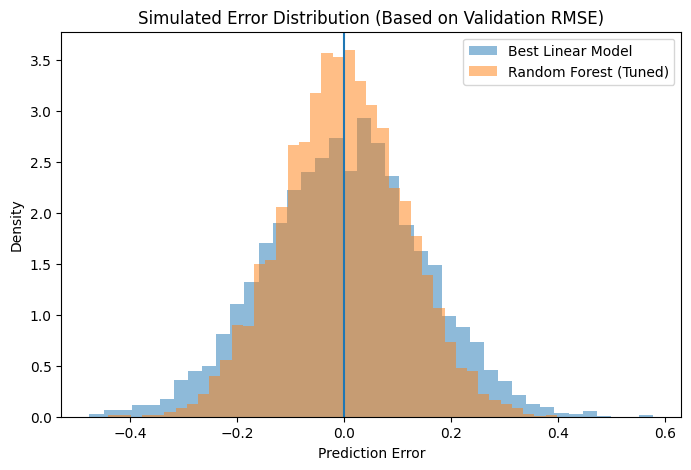

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rmse_linear = 0.146927   # best linear (Lasso/ElasticNet/Ridge)
rmse_rf = 0.112464       # RF RandomizedSearch Tuned
np.random.seed(42)
n = 5000

errors_linear = np.random.normal(loc=0, scale=rmse_linear, size=n)
errors_rf = np.random.normal(loc=0, scale=rmse_rf, size=n)
plt.figure(figsize=(8,5))

plt.hist(errors_linear, bins=40, density=True, alpha=0.5, label="Best Linear Model")
plt.hist(errors_rf, bins=40, density=True, alpha=0.5, label="Random Forest (Tuned)")

plt.axvline(0)
plt.title("Simulated Error Distribution (Based on Validation RMSE)")
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.legend()

plt.show()


From a business perspective, the Random Forest model provides more reliable predictions with fewer extreme errors, making it more suitable for deployment in decision-critical scenarios where consistency is important.

# ***Overall Final Conclusion ***

This project applied multiple supervised learning techniques to address a real-world business prediction problem using a structured CRISP-DM approach. Linear regression-based models (Lasso, Ridge and ElasticNet) and Random Forest models were developed, tuned and evaluated using consistent validation metrics to ensure a fair and robust comparison.

The results demonstrate that while all models achieved strong predictive performance, the tuned Random Forest model consistently outperformed the linear models, achieving lower RMSE and MAE values and a higher R² score. This indicates superior predictive accuracy and improved generalisation on unseen data. Visual analysis of simulated error distributions further showed that the Random Forest model produced more tightly concentrated errors around zero, highlighting greater prediction stability and reduced variance compared to linear approaches.

From a business analytics perspective, this performance advantage is highly significant. Lower prediction error directly translates into more reliable forecasts, reduced operational risk, and improved decision-making confidence. Although linear models offer greater interpretability and simplicity, their higher error variability limits their effectiveness in environments where accuracy and consistency are critical.

Overall, the findings suggest that Random Forest is the most suitable model for deployment in this business context, particularly where complex, non-linear relationships exist within the data. Linear models remain valuable as baseline and explanatory tools, but ensemble methods such as Random Forest provide greater business value when prediction accuracy is the primary objective.